In [1]:
#Issues to Deal with
# Bias towards 0 confidence data, model making the same prediction regardless of input image
# Need to properly set up a training dataset -> Analyse the prices of each training image and reduce the number of negative image
# Perhaps double the number of 1 confidence data and include some 0 confidence data
# Look online for ^ above problem

# Approaches Used: (only applied to training data)
# Approach 1: Pad the training data with 0 confidence bboxes such that each image has (Max Labels) of bboxes
# --> Resulted in high bias towards 0 confidence bboxes
# --> Same prediction regardles of input image
# --> Heavy amounts of noise introduced to model

# Approach 2: An Idea developed using Nyquist's Theorem in mind where in max labels in doubled with the number of bboxes for each image up-scaled
# such that each image has an equal number of 1 confidence and 0 confidence images. 1 confidence data would be random duplicates of already existing data
# Problems to note: Chances of overfitting, Greater computation time and cost, Maybe loss of information and introduction of noise.
# Bias is also introduced in cases of 0 1 confidence bboxes. But there is only one image in the training samples.

In [2]:
#import os
#os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
from datasets import load_dataset
#Installing datasets library to access CORD dataset

In [4]:
%matplotlib inline
#inline magic command to make sure all pictures are in line with each cell

#Installing libraries
print("INSTALLING LIBRARIES....")
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import matplotlib.patches as patches
import random
print("LIBRARIES INSTALLED!")

INSTALLING LIBRARIES....
LIBRARIES INSTALLED!


In [5]:
print("DOWNLOADING CORD DATASET...")
cord_dataset = load_dataset("naver-clova-ix/cord-v2")
print("CORD DATASET DOWNLOADED!")
print("Cord dataset type: ", type(cord_dataset))

DOWNLOADING CORD DATASET...


Using custom data configuration naver-clova-ix--cord-v2-c97f979311033a44
Found cached dataset parquet (C:/Users/ik3g20/.cache/huggingface/datasets/naver-clova-ix___parquet/naver-clova-ix--cord-v2-c97f979311033a44/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/3 [00:00<?, ?it/s]

CORD DATASET DOWNLOADED!
Cord dataset type:  <class 'datasets.dataset_dict.DatasetDict'>


In [6]:
#Initialising train, val and test datasets
print("SEPARATING DATASET INTO TRAIN, VALIDATION AND TEST...")
train, val, test = cord_dataset["train"], cord_dataset["validation"], cord_dataset["test"]
print("DATASET SEPERATED!")

SEPARATING DATASET INTO TRAIN, VALIDATION AND TEST...
DATASET SEPERATED!


# Pre-processing data from training, validation and testing datasets
### Initially checking data format
### Seperating target data needed

In [7]:
#Seperating images
train_images = train['image']
train_labels = train['ground_truth']

In [8]:
counts = []
boxes = []
for i in train_labels:
    box = retreiveCoordinates(eval(i))
    counts.append(len(box))
    boxes.append(box)

NameError: name 'retreiveCoordinates' is not defined

In [ ]:
counts.sort(reverse=True)

In [ ]:
a = list(set(counts))

In [ ]:
b = [counts.count(i) for i in a]

In [ ]:
b

In [ ]:
a[-1]

#plt.figure((10,10))
for i in range(9):
    img = np.array(train_images[i])
    plt.subplot(3,3,i+1)
    plt.imshow(img, cmap='gray')
    plt.title(img.shape)
    plt.axis('off')

A label for training data when evaluated using **eval** function gives the following keys:
'gt_parse', 'meta', 'valid_line', 'roi', 'repeating_symbol', 'dontcare'

We do not need: 'roi', 'repeating_symbol' and 'dontcare

gt_parse: Tells us information that we do not need for the problem of region detection
meta: Tells us information such as width, height, id of image
valid_line: **IMPORTANT** for this problem as it gives us all the coordinates of each text point in image

"""
def keyRep(lables, key_str):
    print(key_str.upper() + ":")
    print(lables[key_str])
    print("************************************************")
    

keyRep(a_label, "gt_parse")
keyRep(a_label, "meta")
keyRep(a_label, "valid_line")
"""

**CURRENT PROBLEM:** Detect dense regions in given receipt

In order to tackle this problem, we need to process the given coordinates into the following format for each image (min x1, min y1, max x3, max y3)

Each element of valid line has the following keys: words, category, group_id, sub_group_id

words: contains the coordinates
- Each element of words contain keys: quad, is_key, row_id, text
- quad: contains the actual coordinates
- text: contains the text at given coordinate

In [ ]:
IMG_SIZE = 256
MAX_LABELS = 22

In [ ]:
print("Defining function to retreive [x1, y1, x3, y3] coordinates of each datapoint")

#Retreiving coordinates with category == menu.price
def retreiveCoordinates(labels):
    coords = []
    vline = labels["valid_line"]
    #Using a nested loop to get all coordinates for given label
    for line in vline: #run through n lines for label
        if (line["category"] == "menu.price"): # Retreiving only prices from labels
            words = line['words']
            for word in words: #run through n words in each line and retreive the coordinates of said word
                quad = word['quad']
                box = [quad['x1'], quad['y1'], quad['x3'], quad['y3']]
                coords.append(box)
    
    return coords

In [ ]:
print("Defining function to get (min x1, min y1, max x3, max y3)")

def singleBoxCoord(label):
    coords = retreiveCoordinates(label)
    x1 = [coord[0] for coord in coords] #Get all x1
    y1 = [coord[1] for coord in coords] #Get all y1
    x3 = [coord[2] for coord in coords] #Get all x3
    y3 = [coord[3] for coord in coords] #Get all y3
    
    PAD = 20 #pad the bounding boxes to get dense box
    
    singleBox = [min(x1)-PAD, min(y1)-PAD, max(x3)+PAD, max(y3)+PAD] #define the dense bounding box
    return singleBox

In [ ]:
print("Defining a displaying function to display images with dense box on them")

def showDBox(img_index):
    img = train_images[img_index]
    img_label = eval(train_labels[img_index])
    width, height = img_label['meta']['image_size']['width'], img_label['meta']['image_size']['height']
    dBox_img = singleBoxCoord(img_label)
    fig, ax = plt.subplots() #make a subplot

    ax.imshow(img) #draw the image on the axis of the subplots
    x1 = dBox_img[0]
    y1 = dBox_img[1]
    x3 = dBox_img[2]
    y3 = dBox_img[3]
    rect = patches.Rectangle((x1, y1), (x3-x1), (y3-y1), linewidth=1, edgecolor='r', facecolor='none')
    #Draw a rectangle using bounding boxes 
    ax.add_patch(rect)

    plt.title("WxH: ({0},{1}) | {2}".format(width, height, dBox_img))
    plt.axis('off')
    plt.show()

In [ ]:
print("Defining pre-process function for images")

def flatten_list(list_imgs):
    return [img_data for data_list in list_imgs for img_data in data_list]

def pre_process_images(images):
    #resize images and then change them into an np array
    new_images = [[img_to_array(image.resize((IMG_SIZE,IMG_SIZE)))] * 2 for image in images]

    new_images = flatten_list(new_images)
    #normalize the values of the arrays
    new_images = np.array(new_images, dtype='float32') / 255.0
    return new_images

def pre_process_images_dense(images):
    #resize images and then change them into an np array
    new_images = [[img_to_array(image.resize((IMG_SIZE,IMG_SIZE)))] for image in images]

    new_images = flatten_list(new_images)
    #normalize the values of the arrays
    new_images = np.array(new_images, dtype='float32') / 255.0
    return new_images

In [ ]:
#Defining a function to return the IoU loss of two bboxes
def inter_over_union(dBoxA, dBoxB):
    inter_x1 = max(dBoxA[0], dBoxB[0])
    inter_y1 = max(dBoxA[1], dBoxB[1])
    inter_x3 = min(dBoxA[2], dBoxB[2])
    inter_y3 = min(dBoxA[3], dBoxB[3])
    
    if (inter_x3 < inter_x1) or (inter_y3 < inter_y1):
        return 0
    
    inter_area = (inter_x3 - inter_x1) * (inter_y3 - inter_y1)
    
    union_A = (dBoxA[2] - dBoxA[0]) * (dBoxA[3] - dBoxA[1])
    union_B = (dBoxB[2] - dBoxB[0]) * (dBoxB[3] - dBoxB[1])
    
    union_area = (union_A + union_B) - inter_area
    
    return (inter_area / union_area)

In [ ]:
def generateBBox(width, height):
    centre = [0.5 * width, 0.5 * height]
    
    return [centre[0], centre[1], centre[0] + 10, centre[1] + 10]

In [ ]:
# Returns a list of random numbers given a value
# Used to randomly return a list of coordinates given the width/height of an image as a base
def genListRandNumber(max_val):
    
    list_of_vals = []
    while len(list_of_vals) < 3:
        list_of_vals = [random.randint(0, max_val) for i in range(10)]
        list_of_vals = list(set(list_of_vals))
    
    return list_of_vals

# Returns a randomly generated DBox
# Used to get a negative class (0) DBox for an image
def getNegDBox(width, height):
    xs = genListRandNumber(width)
    ys = genListRandNumber(height)
    
    x1, y1 = min(xs), min(ys)
    x3, y3 = max(xs), max(ys)
    
    return [x1, y1, x3, y3]

# Generates the negative class (0) DBox given the positive class DBox(1) using Intersection-over-Union method
def generateNegBox(dBox, width, height, multiple=False):
    negBox = [0,0,0,0]
    iou = 1
    
    while iou > 0.3:
        negBox = getNegDBox(width, height)
        if not(multiple):
            iou = inter_over_union(dBox, negBox)
        else:
            ious = [inter_over_union(box, negBox) for box in dBox]
            #print(dBox)
            l_iou = len(ious)
            iou = sum(ious) / l_iou
    
    return negBox
    
def generateNNegBox(count, bBoxes, width, height):
    
    negBoxes = []
    randBox = bBoxes
    if (len(bBoxes) == 0):
        randBox = [generateBBox(width, height)]
    
    for i in range(count):
        negBox = generateNegBox(randBox, width, height, multiple=True)
        
        while negBox in negBoxes:
            negBox = generateNegBox(randBox, width, height, multiple=True)
        
        negBoxes.append(negBox)
    
    return negBoxes

In [ ]:
def normalize(bbox, width, height):
    return [
        bbox[0] / width,
        bbox[1] / height,
        bbox[2] / width,
        bbox[3] / height
           ]

# defining a function to up-sample the 1 confidence bboxes with handling for cases with 0 1 confidence boxes
# Returns the bboxes and confidence scores in list format
def duplicateOneConf(bboxes, width, height):
    if (len(bboxes) >= MAX_LABELS):
        outBoxes = bboxes[:MAX_LABELS]
        outScores = [1] * MAX_LABELS
        return outBoxes, outScores
    elif (len(bboxes) == 0):
        negBoxes = generateNNegBox(MAX_LABELS, [], width, height)
        outBoxes = negBoxes
        outScores = [0] * MAX_LABELS
        return outBoxes, outScores
        
    dupBoxes = bboxes * (int(MAX_LABELS / len(bboxes)) + 1)
    
    outBoxes = dupBoxes[:MAX_LABELS]
    outScores = [1] * MAX_LABELS
    
    return outBoxes, outScores
    
    

In [ ]:
print("Defining pre-process function for labels")

def pre_process_label(label):
    pos_and_negs = []
    conf_scores = []
    ev_lab = eval(label)
    width, height = ev_lab['meta']['image_size']['width'], ev_lab['meta']['image_size']['height']
    dBox = singleBoxCoord(ev_lab)
    #normalize the dbox coordinates using original width and height such that the values are between 0 and 1
    pos_labels = normalize(dBox, width, height)

    
    pos_and_negs.append(pos_labels) #Adding the positive (correct dBox coordinates) sample | 1 denotes correct dBox
    conf_scores.append(1)
    negBox = generateNegBox(dBox, width, height)
    
    neg_labels = normalize(negBox, width, height)
    

    pos_and_negs.append(neg_labels)
    conf_scores.append(0)
        
    return pos_and_negs, conf_scores

def pre_process_label_dense(label):
    ev_lab = eval(label)
    width, height = ev_lab['meta']['image_size']['width'], ev_lab['meta']['image_size']['height']
    retBoxes = retreiveCoordinates(ev_lab)
    bBoxes, conf_scores = duplicateOneConf(retBoxes, width, height)
    bBoxes_norm = [normalize(box, width, height) for box in bBoxes]
    
    outBoxes = []
    outScores = []
    outBoxes.extend(bBoxes_norm)
    outScores.extend(conf_scores)
    remaining = MAX_LABELS
    
    """
    if (len(bBoxes_norm) >= MAX_LABELS):
        return bBoxes_norm[:MAX_LABELS], conf_scores[:MAX_LABELS]
    else:
        # Deal with cases where bBoxes_norm has len = 0
        outBoxes.extend(bBoxes_norm)
        outScores.extend(conf_scores)
        remaining = MAX_LABELS - len(bBoxes_norm)
    """
    
    nNegBoxes = generateNNegBox(remaining, bBoxes, width, height)
    nNegBoxes_norm = [normalize(box, width, height) for box in nNegBoxes]
    nConf_scores = [0] * len(nNegBoxes_norm)
    outBoxes.extend(nNegBoxes_norm)
    outScores.extend(nConf_scores)
    
    return outBoxes, outScores

def pre_process_labels(labels, dense=False):
    new_labels = []
    confScores = []
    for label in labels:
        #pre-process each label
        if not(dense):
            nLabel, confScore = pre_process_label(label)
            new_labels.extend(nLabel)
            confScores.extend(confScore)
        else:
            nLabel, confScore = pre_process_label_dense(label)
            new_labels.append(nLabel)
            confScores.append(confScore)
        
    new_labels = np.array(new_labels)
    confScores = np.array(confScores)
    
    return new_labels, confScores

In [ ]:
print("Pre-processing the datasets...")

tImages, (tLabels, tgLabels) = pre_process_images_dense(train_images), pre_process_labels(train_labels, dense=True)

print("Training Data: Processed")

In [ ]:
vImages, vLabels = pre_process_images_dense(val['image']), pre_process_labels(val['ground_truth'], dense=True)

print("Validation Data: Processed")

# Model

In [ ]:
#CORE CONSTANTS
IMG_INDEX = 1 #Min is 0, Max is 799
BATCH = 32
EPOCHS = 50
L_RATE = 0.001

In [ ]:
training_dataset = tf.data.Dataset.from_tensor_slices((tImages,(tgLabels, tLabels)))

In [ ]:
training_dataset = training_dataset.shuffle(buffer_size=len(tImages))
training_dataset = training_dataset.batch(BATCH)
training_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
def getFeatureExtracter():
    # Defining the input layer
    input_layer = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    # Using vgg16 as the feature extractor
    featureExtractor = ResNet50(weights="imagenet", include_top=False, input_tensor=input_layer)
    
    return input_layer, featureExtractor

In [ ]:
def getModel():
    num_labels = MAX_LABELS * 2
    
    input_layer, fe_layer = getFeatureExtracter()
    
    x = fe_layer.output
    x = Conv2D(256, (3,3), padding="same", activation="relu", name="Conv_Layer_1_Post_FE")(x)
    x = MaxPooling2D()(x)
    x = Flatten()(x)
    x = Dense(512, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation="relu")(x)
    
    confScores = Dense(1 * num_labels, activation="sigmoid", name="Confidence_Scores")(x)
    Bbox_coords = Dense(4 * num_labels, activation="sigmoid", name="BBox_regression")(x)
    Bbox_coords_RS = Reshape((num_labels, 4), name="Bbox")(Bbox_coords)
    
    model = Model(inputs=input_layer, outputs=[confScores, Bbox_coords_RS])
    
    model.compile(optimizer="adam", loss=["binary_crossentropy", "mse"], metrics=["accuracy"])
    return model
    
    

In [ ]:
def train(save_path, dataset):
    model = getModel()
    
    callback_cp = tf.keras.callbacks.ModelCheckpoint(
        filepath=save_path, verbose=1, save_weights_only=True,
        save_freq= "epoch")
    
    train_history = model.fit(dataset, batch_size=BATCH, callbacks = [callback_cp], epochs=EPOCHS)
    
    return model, train_history

In [ ]:
save_path = "./Saved Model/Dense Object Detection Approach2-Prices/"

In [ ]:
model, history = train(save_path, training_dataset)

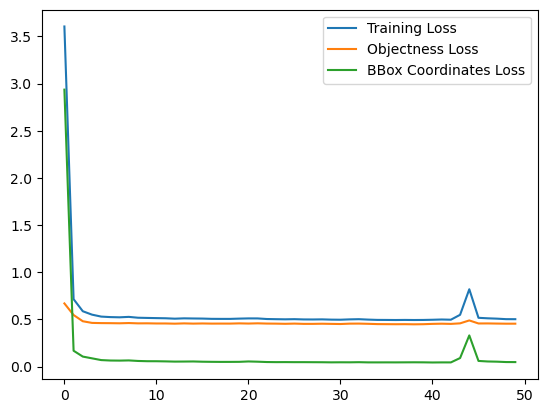

In [236]:
epochs_range = range(EPOCHS)

plt.plot(epochs_range, history.history["loss"], label='Training Loss')
plt.plot(epochs_range, history.history["objectness_loss"], label='Objectness Loss')
plt.plot(epochs_range, history.history["bbox_Coordinates_loss"], label='BBox Coordinates Loss')
plt.legend(loc='upper right')
plt.show()

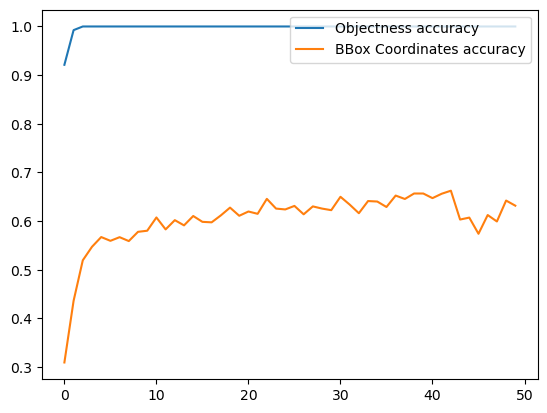

In [237]:
plt.plot(epochs_range, history.history["objectness_accuracy"], label='Objectness accuracy')
plt.plot(epochs_range, history.history["bbox_Coordinates_accuracy"], label='BBox Coordinates accuracy')
plt.legend(loc='upper right')
plt.show()

In [44]:
history.history.keys()

dict_keys(['loss', 'objectness_loss', 'bbox_Coordinates_loss', 'objectness_accuracy', 'bbox_Coordinates_accuracy'])

checkpoint = ModelCheckpoint(
    filepath="./checkpoint",
    save_weights_only=True,
    monitor="val_loss",
    mode="min",
    save_best_only=True
) 

In [319]:

def test_image(idx):
    test_data = test['image'][idx]
    tl = eval(test['ground_truth'][idx])
    w,h = tl['meta']['image_size']['width'], tl['meta']['image_size']['height']

    test_data = img_to_array(test_data.resize((IMG_SIZE,IMG_SIZE)))
    test_data = np.expand_dims(test_data, axis=0)
    
    preds = model.predict(test_data)
    
    isPos, dBox = preds
    print(isPos[0])
    print(dBox[0])
    boxes = []
    poses = []
    for index, i in enumerate(isPos[0]):
        if i >= 0.7:
            boxes.append(dBox[0][index])
            poses.append(i)
    
    norm_boxes = [unnormalize(box, w, h) for box in boxes]
    
    fig, ax = plt.subplots()

    ax.imshow(test["image"][idx])
    for i in norm_boxes:
        x1,y1,x3,y3 = i
        bbox = patches.Rectangle((x1, y1), (x3-x1), (y3-y1), linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(bbox)
    
    gt_bbox = retreiveCoordinates(tl)
    #iou = inter_over_union(gt_bbox, box)
    
    for i in gt_bbox:
        x1,y1,x3,y3 = i
        bbox_gt = patches.Rectangle((x1, y1), (x3-x1), (y3-y1), linewidth=1, edgecolor='g', facecolor='none')
        ax.add_patch(bbox_gt)
        
    plt.title("WxH: ({0},{1})".format(w, h))
    plt.axis('off')
    plt.show()

[0.99674284 0.5638153  0.34782296 0.20796964 0.14379331]
[[0.6608558  0.44117513 0.75962603 0.46111608]
 [0.41089106 0.2933708  0.8073588  0.6511835 ]
 [0.27759367 0.21340786 0.81490046 0.73053366]
 [0.19242819 0.15915003 0.8076651  0.7879045 ]
 [0.17446907 0.1352626  0.81255364 0.80393445]]


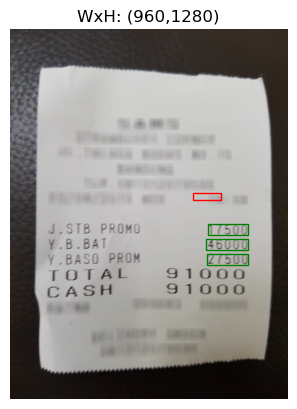

In [320]:
test_image(1)

[0.99674284 0.5638153  0.34782296 0.20796964 0.14379331]
[[0.6608558  0.44117513 0.75962603 0.46111608]
 [0.41089106 0.2933708  0.8073588  0.6511835 ]
 [0.27759367 0.21340786 0.81490046 0.73053366]
 [0.19242819 0.15915003 0.8076651  0.7879045 ]
 [0.17446907 0.1352626  0.81255364 0.80393445]]


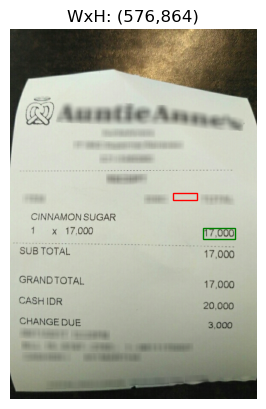

In [321]:
test_image(10)

[0.99674284 0.5638153  0.34782296 0.20796964 0.14379331]


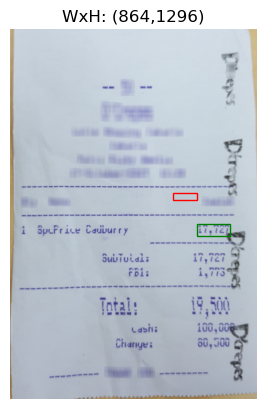

In [316]:
test_image(50)

[0.99674284 0.5638153  0.34782296 0.20796964 0.14379331]


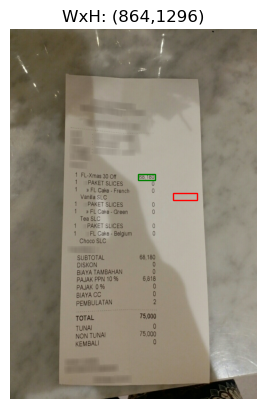

In [317]:
test_image(99)

In [23]:
#model.save("./Save-Models/Initial-Base-Model/")

INFO:tensorflow:Assets written to: ./Save-Models/Initial-Base-Model/assets


INFO:tensorflow:Assets written to: ./Save-Models/Initial-Base-Model/assets
